In [2]:
import numpy as np
import scipy as sp
import scipy.io as sio
import matplotlib.pyplot as plt
from PIL import Image
import random as rand
import pathlib
from shutil import copyfile
import os
import random
from IPython.display import display
import imageio
from glob import glob
from collections import defaultdict
import math

In [3]:
# os.chdir('/Users/kev/Code/classes/cmsc498m/Project1/notebooks')

In [4]:
TRAINPATH = '../data/processed/illumination/train/'
TESTPATH = '../data/processed/illumination/test/'

In [5]:
class Face():
    def __init__(self, filepath):
        self.vector = self.load_image(filepath)
    
    @property
    def image(self):
        return self.recover_img(self.vector)
        
    def load_image(self, filepath):
        return imageio.imread(filepath).flatten(order='F')  # column-major flatten

    def recover_img(self, v, dim1=40, dim2=48, rotate=270):
        rescaled = v.reshape(dim1, dim2)
        return Image.fromarray(rescaled).rotate(rotate, expand=True)
    
    def __str__(self):
        return "Face<" + str(self.vector) + ">"

class Person():
    """Person (for a series of face photos)."""
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.faces = [Face(file) for file in self.get_image_files(root_dir)]
        
    @property
    def id(self):
        person_str = self.root_dir.split('/')[-2]
        person_no = int(''.join([s for s in person_str if s.isdigit()]))
        return person_no
        
    def get_image_files(self, dir):
        return [filename for filename in glob(dir + os.sep + '*.tif')]
    
    def __str__(self):
        return "Person<" + str(self.id) + ">"
    
class FaceDataset():
    """Illumination Dataset."""
    
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.persons = [Person(dir) for dir in glob(root_dir + '*/')]
        
    @property
    def images(self):
        return glob(self.root_dir + '/*/*.png')
        
    @property
    def num_persons(self):
        return len(self.persons)
    
    @property
    def num_images(self):
        return sum([len(person) for person in self.persons])
        

In [6]:
train = FaceDataset(TRAINPATH)
test = FaceDataset(TESTPATH)

/usr/local/Cellar/python3/3.6.4/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/imageio/plugins/_tifffile.py:7285: UserWarning: module 'imageio.plugins._tifffile' has no attribute 'decode_packbits'
  Functionality might be degraded or be slow.

  warnings.warn("%s%s" % (e, warn))
/usr/local/Cellar/python3/3.6.4/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/imageio/plugins/_tifffile.py:7285: UserWarning: module 'imageio.plugins._tifffile' has no attribute 'decode_lzw'
  Functionality might be degraded or be slow.

  warnings.warn("%s%s" % (e, warn))
/usr/local/Cellar/python3/3.6.4/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/imageio/plugins/_tifffile.py:7285: UserWarning: module 'imageio.plugins._tifffile' has no attribute 'unpack_ints'
  Functionality might be degraded or be slow.

  warnings.warn("%s%s" % (e, warn))
/usr/local/Cellar/python3/3.6.4/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/im

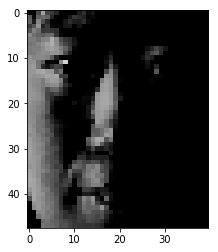

In [7]:
# for person in train.persons:
#     for face in person.faces:
#         print(person)
#         print(face)
        
img = train.persons[0].faces[0].image
plt.imshow(img)

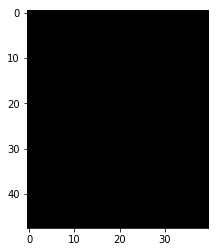

In [8]:
avg = [0]
for person in train.persons:
    for face in person.faces:
        avg += face.vector
    
img = Face.recover_img(None, avg)
plt.imshow(img)

# PCA

In [9]:
%%time
v = np.asarray(train.persons[0].faces[0].vector)[np.newaxis].T
for person in train.persons:
    for face in person.faces:
        new_v = face.vector[np.newaxis].T
        v = np.append(v, new_v, axis=1)

cov = np.cov(v)
display(cov)

array([[2165.69141533, 2141.80608953, 2095.99820338, ..., -738.94506992,
        -680.81930245, -663.77310097],
       [2141.80608953, 2194.69672409, 2175.66858839, ..., -792.23865706,
        -737.43719507, -717.32655034],
       [2095.99820338, 2175.66858839, 2208.30374742, ..., -837.81277658,
        -785.5107728 , -763.93534827],
       ...,
       [-738.94506992, -792.23865706, -837.81277658, ..., 2629.98236325,
        2704.68950545, 2666.01387191],
       [-680.81930245, -737.43719507, -785.5107728 , ..., 2704.68950545,
        2876.43108204, 2857.89556077],
       [-663.77310097, -717.32655034, -763.93534827, ..., 2666.01387191,
        2857.89556077, 2942.70863205]])

CPU times: user 1.4 s, sys: 2.24 s, total: 3.64 s
Wall time: 3.43 s


In [10]:
eigvals, eigvecs = sp.linalg.eigh(cov)

In [11]:
%%time
# Sort by top eigenvalues
idx = eigvals.argsort()[::-1]   
eigvals = eigvals[idx]
eigvecs = eigvecs[:,idx]

max([max(v) for v in eigvecs[1:100]])

CPU times: user 24.3 ms, sys: 8.29 ms, total: 32.6 ms
Wall time: 31.1 ms


Text(0.5,0.98,'Top 100 Eigenfaces (PCA)')

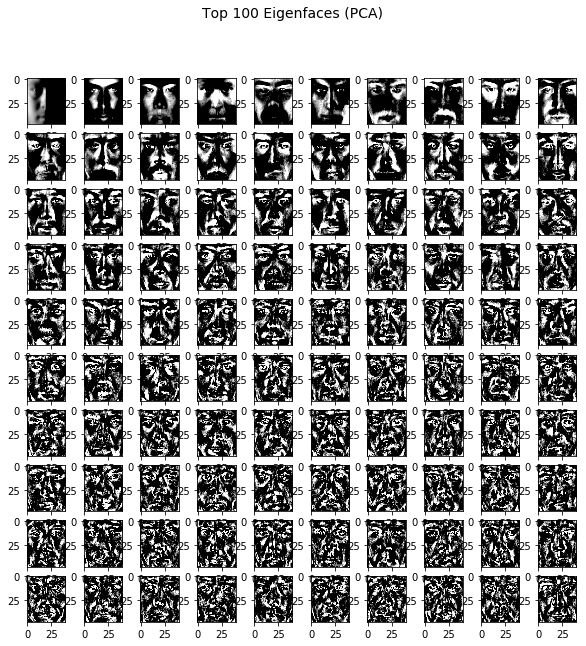

In [12]:
scale=1
fig=plt.figure(figsize=(10*scale, 10*scale))
columns = 10
rows = 10
for i in range(1, 101):
    img = Face.recover_img(None, eigvecs[:,i]*1e4)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
fig.suptitle('Top 100 Eigenfaces (PCA)', fontsize=14)

# LDA

In [12]:
# Get mean vectors for each class (person) of training set
mean_vectors = []
for person in train.persons:
    avg = sum([face.vector for face in person.faces])/len(person.faces)
    mean_vectors.append(avg)

In [13]:
# Compute within-class scatter matrix
S_W = np.zeros((len(mean_vectors[0]), len(mean_vectors[0])))
for i, person in enumerate(train.persons):
    S_i = np.zeros((len(mean_vectors[0]), len(mean_vectors[0])))
    for face in person.faces:
        fv = face.vector[np.newaxis].T
        mv = mean_vectors[i][np.newaxis].T
        S_i += (fv - mv) @ (fv - mv).T
    S_W += S_i

In [14]:
# Compute between-class scatter matrix
complete_mean = np.mean([face.vector for person in train.persons for face in person.faces], axis=0)  # mean, should be ~0

S_B = np.zeros((len(mean_vectors[0]), len(mean_vectors[0])))
for i, _ in enumerate(mean_vectors):
    n = len(train.persons[i].faces)  # redundant because constant class size
    cm = complete_mean[np.newaxis].T
    mv = mean_vectors[i][np.newaxis].T
    S_B += n * (mv - cm) @ (mv - cm).T

In [15]:
display(S_W, S_B)

array([[1668116.85166791, 1687009.4088358 , 1694614.61296777, ...,
        -879494.1776133 , -863495.56594261, -876400.69161927],
       [1687009.4088358 , 1741156.80717124, 1753406.3277333 , ...,
        -898178.98553102, -882401.37939838, -893777.84933808],
       [1694614.61296777, 1753406.3277333 , 1793822.85491725, ...,
        -912308.03416984, -896226.90189183, -908050.81414035],
       ...,
       [-879494.1776133 , -898178.98553102, -912308.03416984, ...,
        1575598.34719098, 1554383.96769414, 1513953.98487192],
       [-863495.56594261, -882401.37939838, -896226.90189183, ...,
        1554383.96769414, 1580520.82015349, 1551192.91364542],
       [-876400.69161927, -893777.84933808, -908050.81414035, ...,
        1513953.98487192, 1551192.91364542, 1604744.13054921]])

array([[ 6.86732926e+05,  6.41700103e+05,  5.84226810e+05, ...,
         7.42752989e+04,  1.21465355e+05,  1.52797602e+05],
       [ 6.41700103e+05,  6.44928222e+05,  6.11943855e+05, ...,
         3.48425710e+04,  7.86311861e+04,  1.11756077e+05],
       [ 5.84226810e+05,  6.11943855e+05,  6.07001544e+05, ...,
        -6.38548393e+02,  4.01260591e+04,  7.52896388e+04],
       ...,
       [ 7.42752989e+04,  3.48425710e+04, -6.38548393e+02, ...,
         1.28472983e+06,  1.38717990e+06,  1.38542637e+06],
       [ 1.21465355e+05,  7.86311861e+04,  4.01260591e+04, ...,
         1.38717990e+06,  1.54785029e+06,  1.55690276e+06],
       [ 1.52797602e+05,  1.11756077e+05,  7.52896388e+04, ...,
         1.38542637e+06,  1.55690276e+06,  1.59550939e+06]])

In [27]:
%%time
# Solving Eigenvalue Problem for S−1W Sb
eigvals2, eigvecs2 = sp.linalg.eigh(np.linalg.inv(S_W) @ (S_B))

CPU times: user 5.3 s, sys: 139 ms, total: 5.44 s
Wall time: 2.12 s


In [28]:
eigvals2

array([-9.19809327e+09, -3.59032476e+09, -3.12688969e+09, ...,
        3.26455676e+09,  3.57330773e+09,  9.09061684e+09])

In [29]:
idx = eigvals2.argsort()[::-1]   
eigvals2 = eigvals2[idx]
eigvecs2 = eigvecs2[:,idx]

Text(0.5,0.98,'Top 100 Fisherfaces')

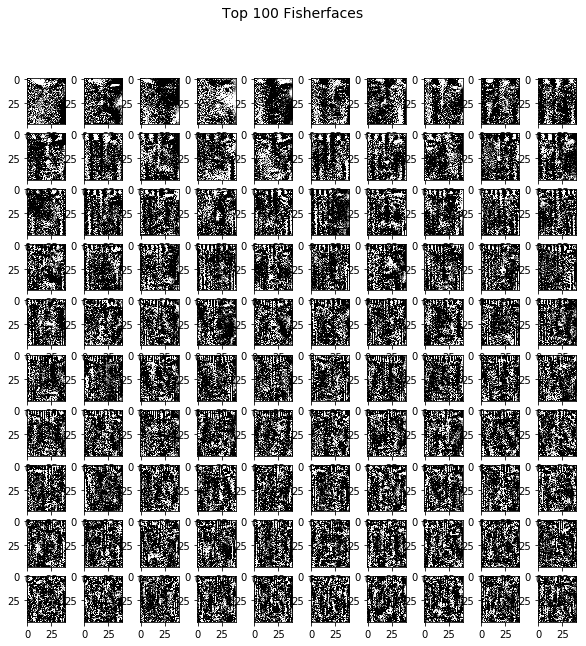

In [30]:
scale=1
fig=plt.figure(figsize=(10*scale, 10*scale))
columns = 10
rows = 10
for i in range(1, 101):
    img = Face.recover_img(None, eigvecs2[:,i]*1e4)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
fig.suptitle('Top 100 Fisherfaces', fontsize=14)

# KNN

In [13]:
# Get image vectors and class labels of training set
train_X = []
train_Y = []
for person in train.persons:
    for face in person.faces:
        train_X.append(face.vector)
        train_Y.append(person.id)

In [14]:
# Get image vectors and class labels of test set
test_X = []
test_Y = []
for person in test.persons:
    for face in person.faces:
        test_X.append(face.vector)
        test_Y.append(person.id)

In [15]:
def euclideanDistance(v1, v2):
    if (len(v1) != len(v2)):
        raise Exception("Vectors not equal")
    distance = 0
    for x in range(min(len(v1),len(v2))):
        distance += math.pow((v1[x] - v2[x]), 2)
    return math.sqrt(distance)

In [144]:
from queue import PriorityQueue

def getNeighbors(train_set, train_labels, test, k):
    distances = PriorityQueue()
    for i in range(len(train_set)):
       distances.put((euclideanDistance(test, train_set[i]), train_labels[i]))
    neighbors = []
    for _ in range(k):
        neighbors.append(distances.get())
    return neighbors

In [173]:
def getMajorityVote(neighbors):
    votes = defaultdict(int)
    for i in range(len(neighbors)):
        label = neighbors[i][-1]
        votes[label] += 1
    return sorted(votes.items(), key=lambda k_v: k_v[1])[-1][0]

In [196]:
class KNNClassifier():
    def __init__(self, neighbors=1):
        self.neighbors = neighbors
        self.train_set = None
        self.train_labels = None
        
    def fit(self, train_set, train_labels):
        self.train_set = train_set
        self.train_labels = train_labels
        
    def predict(self, test_image):
        if self.train_set is None or self.train_labels is None:
            raise Exception
            
        neighbors = getNeighbors(self.train_set, self.train_labels, test_image, self.neighbors)
        response = getMajorityVote(neighbors)
        return response
    
    def score(self, test_set, test_labels):
        correct = 0.
        for i in range(len(test_set)):
            if self.predict(test_set[i]) == test_labels[i]:
                correct += 1.
        return correct / len(test_set)

In [307]:
%%timeit
model = KNNClassifier(neighbors=1)
model.fit(train_X, train_Y)
model.predict(test_X[99])

1.08 s ± 30.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [218]:
%%time
model = KNNClassifier(neighbors=1)
model.fit(train_X, train_Y)
acc = model.score(test_X, test_Y)

CPU times: user 6min 9s, sys: 938 ms, total: 6min 10s
Wall time: 6min 11s


In [31]:
acc

NameError: name 'acc' is not defined

## LDA then KNN

In [538]:
eigvecs_lda_f = eigvecs2[:,:10]
eigvecs_lda_f

array([[-0.00956664,  0.00225788, -0.01569889, ..., -0.00481591,
         0.02613675, -0.00370082],
       [-0.01488154, -0.00325577, -0.01358554, ..., -0.0104494 ,
         0.02689807, -0.00049563],
       [-0.01750386, -0.00584464, -0.01389236, ..., -0.00986732,
         0.02732138,  0.00369247],
       ...,
       [-0.01730635,  0.03334745, -0.0278247 , ..., -0.01575328,
         0.01041266, -0.04595402],
       [-0.01200604, -0.00241123,  0.06988722, ...,  0.02757701,
         0.00907583,  0.04260301],
       [ 0.01576542, -0.01996944, -0.01327061, ...,  0.00741643,
        -0.00224144,  0.00587806]])

In [529]:
pr_train_X = project_eigenface(eigvecs_lda_f.T, train_X)
pr_test_X = project_eigenface(eigvecs_lda_f.T, test_X)

## PCA then KNN

In [16]:
eigvecs_f50 = eigvecs[:,:10]  # get first 50 eigvecs
eigvecs_f50

array([[-0.00226145, -0.025027  , -0.01146537, ...,  0.022937  ,
         0.00734408,  0.02484251],
       [-0.00239018, -0.02588956, -0.01295579, ...,  0.02065672,
         0.00909039,  0.02138532],
       [-0.0027461 , -0.0263715 , -0.01541141, ...,  0.0187638 ,
         0.01273359,  0.01972373],
       ...,
       [ 0.01149311,  0.01415494, -0.01650294, ..., -0.12551223,
         0.01735871, -0.00245298],
       [ 0.01228028,  0.01352862, -0.01876114, ..., -0.13090341,
         0.01868523, -0.00314239],
       [ 0.01295127,  0.01349942, -0.01816111, ..., -0.12250026,
         0.01749192, -0.00447728]])

In [17]:
eigvecs_f50_m3 = eigvecs_f50[:,3:]  # delete first three eigvecs
eigvecs_f50_m3

array([[-0.04086506,  0.02667724,  0.02105273, ...,  0.022937  ,
         0.00734408,  0.02484251],
       [-0.04084046,  0.0291704 ,  0.02539454, ...,  0.02065672,
         0.00909039,  0.02138532],
       [-0.03868613,  0.03077655,  0.02412022, ...,  0.0187638 ,
         0.01273359,  0.01972373],
       ...,
       [-0.02855812, -0.0277798 , -0.0533065 , ..., -0.12551223,
         0.01735871, -0.00245298],
       [-0.02931238, -0.02367291, -0.05445615, ..., -0.13090341,
         0.01868523, -0.00314239],
       [-0.02958827, -0.02248274, -0.05247219, ..., -0.12250026,
         0.01749192, -0.00447728]])

In [18]:
# Project Train and Test onto Eigenvector Matrix
def project_eigenface(M, vectors):
    return [M @ v for v in vectors]

pr_train_X = project_eigenface(eigvecs_f50.T, train_X)
pr_test_X = project_eigenface(eigvecs_f50.T, test_X)

In [533]:
%%timeit
model = KNNClassifier(neighbors=10)
model.fit(pr_train_X, train_Y)
model.predict(pr_test_X[10])

11.1 ms ± 339 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [534]:
%%timeit
model = KNNClassifier(neighbors=1)
model.fit(pr_train_X, train_Y)
acc = model.score(pr_test_X, test_Y)

3.74 s ± 32.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [535]:
acc

0.9264705882352942

In [537]:
%%time
accs = []
for i in range(1,6):
    eigvecs_f = eigvecs[:,:i*10]
    pr_train_X = project_eigenface(eigvecs_f.T, train_X)
    pr_test_X = project_eigenface(eigvecs_f.T, test_X)
    model = KNNClassifier(neighbors=1)
    model.fit(pr_train_X, train_Y)
    acc = model.score(pr_test_X, test_Y)
    accs.append(acc)

CPU times: user 37.7 s, sys: 221 ms, total: 37.9 s
Wall time: 38.1 s


In [541]:
accs_lda = []
for i in range(1,6):
    eigvecs_lda_f = eigvecs2[:,:i*10]
    pr_train_X = project_eigenface(eigvecs_lda_f.T, train_X)
    pr_test_X = project_eigenface(eigvecs_lda_f.T, test_X)
    model = KNNClassifier(neighbors=1)
    model.fit(pr_train_X, train_Y)
    acc = model.score(pr_test_X, test_Y)
    accs_lda.append(acc)

Text(0.5,1,'K=1 KNN Dimensionally Reduced Face Recognition')

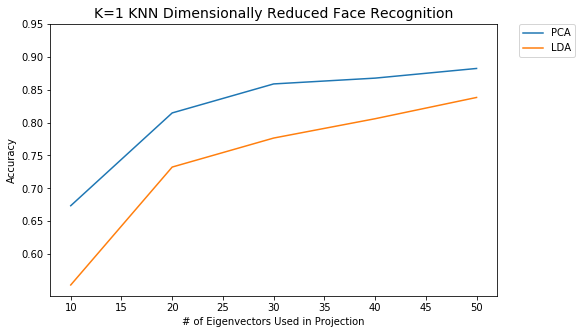

In [555]:
fig = plt.figure(figsize=(8,5))
plt.plot(range(10,60,10), accs, label="PCA")
plt.plot(range(10,60,10), accs_lda, label="LDA")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel('Accuracy')
plt.xlabel('# of Eigenvectors Used in Projection')
plt.yticks(np.arange(0.6,1,0.05))
plt.title('K=1 KNN Dimensionally Reduced Face Recognition', fontsize=14)

In [506]:
# Accuracy of 30 eigenfaces
accs[2]

0.8588235294117647

In [556]:
%%time
accs_deletions = []
for i in range(6):
    eigvecs_f = eigvecs[:,i:30]
    pr_train_X = project_eigenface(eigvecs_f.T, train_X)
    pr_test_X = project_eigenface(eigvecs_f.T, test_X)
    model = KNNClassifier(neighbors=1)
    model.fit(pr_train_X, train_Y)
    acc = model.score(pr_test_X, test_Y)
    accs_deletions.append(acc)

CPU times: user 42.7 s, sys: 265 ms, total: 43 s
Wall time: 43.3 s


In [557]:
accs_deletions_lda = []
for i in range(6):
    eigvecs_lda_f = eigvecs2[:,i:30]
    pr_train_X = project_eigenface(eigvecs_lda_f.T, train_X)
    pr_test_X = project_eigenface(eigvecs_lda_f.T, test_X)
    model = KNNClassifier(neighbors=1)
    model.fit(pr_train_X, train_Y)
    acc = model.score(pr_test_X, test_Y)
    accs_deletions_lda.append(acc)

Text(0.5,1,'K=1 KNN E=30 Face Recognition with Deleted Top Eigenvectors')

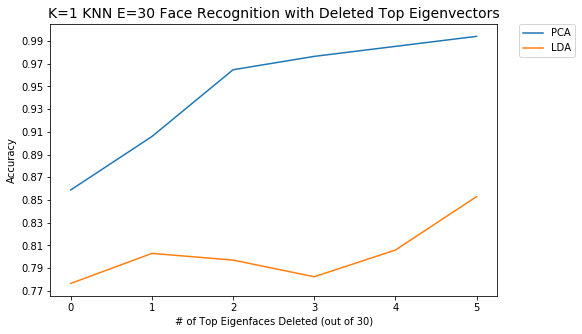

In [660]:
fig = plt.figure(figsize=(8,5))
plt.plot(range(6), accs_deletions, label="PCA")
plt.plot(range(6), accs_deletions_lda, label="LDA")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel('Accuracy')
plt.xlabel('# of Top Eigenfaces Deleted (out of 30)')
plt.yticks(np.arange(0.77,1,0.02))
plt.title('K=1 KNN E=30 Face Recognition with Deleted Top Eigenvectors', fontsize=14)

In [509]:
# top 30 - 5
eigvecs_f = eigvecs[:,5:30]
pr_train_X = project_eigenface(eigvecs_f.T, train_X)
pr_test_X = project_eigenface(eigvecs_f.T, test_X)
model = KNNClassifier(neighbors=1)
model.fit(pr_train_X, train_Y)
acc = model.score(pr_test_X, test_Y)

In [510]:
acc

0.9941176470588236

In [578]:
%%time
accs_deletions2 = []
for i in range(24):
    eigvecs_f = eigvecs[:,i+6:30]
    pr_train_X = project_eigenface(eigvecs_f.T, train_X)
    pr_test_X = project_eigenface(eigvecs_f.T, test_X)
    model = KNNClassifier(neighbors=1)
    model.fit(pr_train_X, train_Y)
    acc = model.score(pr_test_X, test_Y)
    accs_deletions2.append(acc)

CPU times: user 1min 41s, sys: 552 ms, total: 1min 41s
Wall time: 1min 42s


In [592]:
%%time
accs_deletions2_lda = []
for i in range(24):
    eigvecs_lda_f = eigvecs2[:,i+6:30]
    pr_train_X = project_eigenface(eigvecs_lda_f.T, train_X)
    pr_test_X = project_eigenface(eigvecs_lda_f.T, test_X)
    model = KNNClassifier(neighbors=1)
    model.fit(pr_train_X, train_Y)
    acc = model.score(pr_test_X, test_Y)
    accs_deletions2_lda.append(acc)

CPU times: user 1min 42s, sys: 623 ms, total: 1min 43s
Wall time: 1min 44s


Text(0.5,1,'K=1 KNN E=30 Face Recognition with Deleted Top Eigenvectors')

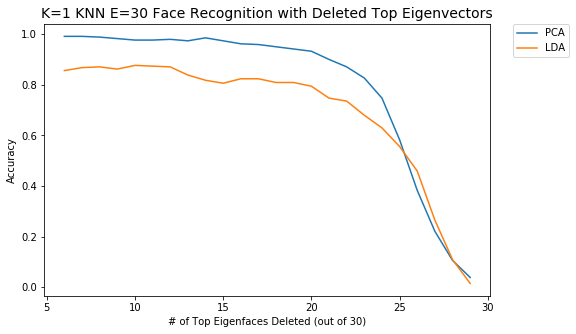

In [662]:
fig = plt.figure(figsize=(8,5))
plt.plot(range(6,30), accs_deletions2, label="PCA")
plt.plot(range(6,30), accs_deletions2_lda, label="LDA")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel('Accuracy')
plt.xlabel('# of Top Eigenfaces Deleted (out of 30)')
plt.title('K=1 KNN E=30 Face Recognition with Deleted Top Eigenvectors', fontsize=14)

In [594]:
%%time
# top 30 - top 15
eigvecs_f = eigvecs[:,5:30]
eigvecs_lda_f = eigvecs2[:,5:30]

accs_neighbors = []
accs_neighbors_lda = []
for i in range(1,6):
    pr_train_X = project_eigenface(eigvecs_f.T, train_X)
    pr_test_X = project_eigenface(eigvecs_f.T, test_X)
    model = KNNClassifier(neighbors=i)
    model.fit(pr_train_X, train_Y)
    acc = model.score(pr_test_X, test_Y)
    accs_neighbors.append(acc)
    
    pr_train_X = project_eigenface(eigvecs_lda_f.T, train_X)
    pr_test_X = project_eigenface(eigvecs_lda_f.T, test_X)
    model = KNNClassifier(neighbors=i)
    model.fit(pr_train_X, train_Y)
    acc = model.score(pr_test_X, test_Y)
    accs_neighbors_lda.append(acc)

CPU times: user 1min 5s, sys: 348 ms, total: 1min 6s
Wall time: 1min 6s


Text(0.5,1,'KNN D=30 (-5) Face Recognition with Varying K')

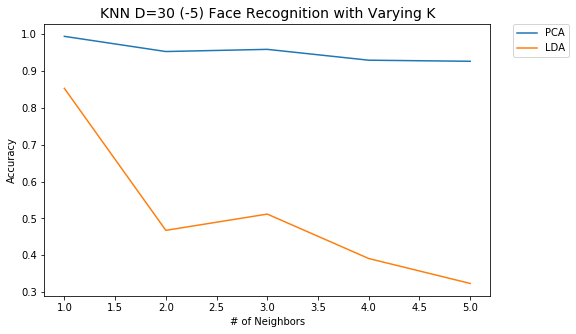

In [596]:
fig = plt.figure(figsize=(8,5))
plt.plot(range(1,6), accs_neighbors, label="PCA")
plt.plot(range(1,6), accs_neighbors_lda, label="LDA")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel('Accuracy')
plt.xlabel('# of Neighbors')
plt.title('KNN D=30 (-5) Face Recognition with Varying K', fontsize=14)

In [19]:
accs2

NameError: name 'accs2' is not defined

# Bayes Classifer

In [19]:
def calc_gaussian_probability(x, mean, variance):
    # Gaussian PDF (given mean and variance)
    scalar = (1 / (math.sqrt(2 * math.pi * variance)))
    return scalar * math.exp(-(math.pow(x - mean, 2) / (2 * variance)))

In [57]:
class GaussianBayesClassifier():
    def __init__(self):
        self.train_set = None
        self.train_labels = None
        
    def fit(self, train_set, train_labels):
        self.train_set = train_set
        self.train_labels = train_labels
        self.train_mean_variances = defaultdict(list)  # mean/variances per class
        
        # Loop through each class
        class_set = []
        for i, label in enumerate(train_labels):
            class_set.append(train_set[i])

            if (i == len(train_labels)-1 or label != train_labels[i+1]):  # last element or next label different
                # Calculate mean/variance of class and reset
    
                # Loop through the all pixel indices
                for j in range(len(train_set[0])):
                    # Calculate mean and variance per pixel across the class set
                    pixel_mean = np.mean([img[j] for img in class_set])
                    pixel_variance = np.var([img[j] for img in class_set])

                    self.train_mean_variances[label].append((pixel_mean, pixel_variance))
                class_set = []
        
    def predict(self, test_image):
        if self.train_set is None or self.train_labels is None:
            raise Exception
        
        # Get per image log likelihood (sum of logs) for every class
        likelihoods = {}
        for person_class in self.train_labels:
            image_likelihood = 0

            # Get per pixel likelihood for every class
            pixel_likelihoods = []
            for idx_pixel, pixel in enumerate(test_image):
                mean, variance = self.train_mean_variances[person_class][idx_pixel]
                pixel_likelihood = calc_gaussian_probability(pixel, mean, variance)
                if pixel_likelihood > 0:
                    pixel_likelihoods.append(math.log(pixel_likelihood))
            image_likelihood = np.sum(pixel_likelihoods)
            # NOTE: Add prior calculation here if nonuniform distribution
            likelihoods[person_class] = image_likelihood
        
        # Get class with highest likelihood
        max_class = max(likelihoods.keys(), key=(lambda key: likelihoods[key]))
        return max_class
    
    def score(self, test_set, test_labels):
        correct = 0.
        for i in range(len(test_set)):
            if self.predict(test_set[i]) == test_labels[i]:
                correct += 1.
        return correct / len(test_set)

In [59]:
model = GaussianBayesClassifier()

accs_bayes_eigs_pca = []
eigvecs_f_pca = eigvecs[:,:i]
pr_train_X = project_eigenface(eigvecs_f_pca.T, train_X)
pr_test_X = project_eigenface(eigvecs_f_pca.T, test_X)

model.fit(pr_train_X, train_Y)
prediction = model.predict(pr_test_X[129])
display(prediction, test_Y[129])


{0: -662.4250163455794,
 1: -698.1836494272003,
 2: -709.3915162113924,
 3: -805.2771432762012,
 4: -673.1778493036126,
 5: -707.3733518675549,
 6: -797.3914341695508,
 7: -930.3658109533027,
 8: -758.9466451147822,
 9: -703.7130822341816,
 10: -616.634051247841,
 11: -707.0360608738133,
 12: -641.8612933742138,
 13: -684.1966872139988,
 14: -639.6923727492232,
 15: -646.7079398275661,
 16: -663.905526171044,
 17: -741.5590217047444,
 18: -624.3660263037801,
 19: -679.3194765492156,
 20: -664.1827368294624,
 21: -924.6668666869083,
 22: -629.7773235191,
 23: -701.2644384558043,
 24: -628.908003646322,
 25: -507.4465082721272,
 26: -691.0692350721807,
 27: -617.0101582776781,
 28: -667.2243504892189,
 29: -666.7462841920507,
 30: -782.6788650863087,
 31: -681.4265806409489,
 32: -634.292453308703,
 33: -720.8367874069403,
 34: -657.3268815156589,
 35: -767.6090359986381,
 36: -656.3408786188444,
 37: -700.1343908013442,
 38: -699.5289339219019,
 39: -764.5430371137849,
 40: -701.4650518

25

25

In [643]:
%%time
accs_bayes_eigs_pca, accs_bayes_eigs_lda = [], []

for i in range(1,50):
    eigvecs_f_pca = eigvecs[:,:i]
    eigvecs_f_lda = eigvecs2[:,:i]
    
    pr_train_X = project_eigenface(eigvecs_f_pca.T, train_X)
    pr_test_X = project_eigenface(eigvecs_f_pca.T, test_X)
    model.fit(pr_train_X, train_Y)
    acc_pca=model.score(pr_test_X, test_Y)
    accs_bayes_eigs_pca.append(acc_pca)
    
    pr_train_X = project_eigenface(eigvecs_f_lda.T, train_X)
    pr_test_X = project_eigenface(eigvecs_f_lda.T, test_X)
    model.fit(pr_train_X, train_Y)
    acc_lda=model.score(pr_test_X, test_Y)
    accs_bayes_eigs_lda.append(acc_lda)

CPU times: user 3.98 s, sys: 23.4 ms, total: 4 s
Wall time: 4.03 s


Text(0.5,1,'Bayes Dimensionally Reduced Face Recognition')

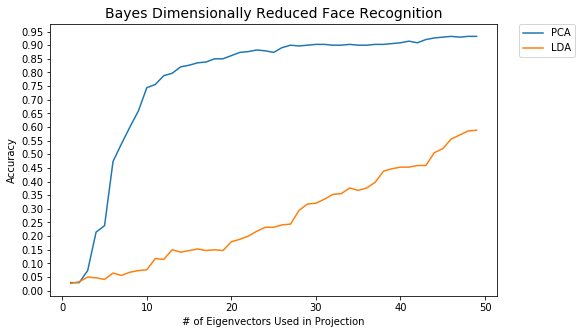

In [644]:
fig = plt.figure(figsize=(8,5))
plt.plot(range(1,50), accs_bayes_eigs_pca, label="PCA")
plt.plot(range(1,50), accs_bayes_eigs_lda, label="LDA")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel('Accuracy')
plt.xlabel('# of Eigenvectors Used in Projection')
plt.yticks(np.arange(0,1,.05))
plt.title('Bayes Dimensionally Reduced Face Recognition', fontsize=14)

In [672]:
%%time
accs_bayes_dels_pca, accs_bayes_dels_lda = [], []

for i in range(49):
    eigvecs_f_pca = eigvecs[:,i:50]
    eigvecs_f_lda = eigvecs2[:,i:50]
    
    pr_train_X = project_eigenface(eigvecs_f_pca.T, train_X)
    pr_test_X = project_eigenface(eigvecs_f_pca.T, test_X)
    model.fit(pr_train_X, train_Y)
    acc_pca=model.score(pr_test_X, test_Y)
    accs_bayes_dels_pca.append(acc_pca)
    
    pr_train_X = project_eigenface(eigvecs_f_lda.T, train_X)
    pr_test_X = project_eigenface(eigvecs_f_lda.T, test_X)
    model.fit(pr_train_X, train_Y)
    acc_lda=model.score(pr_test_X, test_Y)
    accs_bayes_dels_lda.append(acc_lda)

CPU times: user 3.87 s, sys: 94.9 ms, total: 3.97 s
Wall time: 4.1 s


Text(0.5,1,'E=50 Bayes Face Recognition with Deleted Top Eigenvectors')

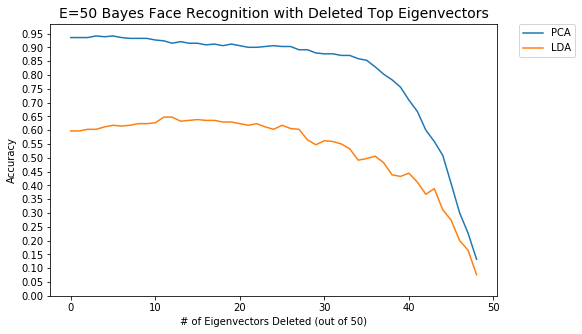

In [673]:
# Maximum Likelihood Estimation with Bayesian Estimation
fig = plt.figure(figsize=(8,5))
plt.plot(range(49), accs_bayes_dels_pca, label="PCA")
plt.plot(range(49), accs_bayes_dels_lda, label="LDA")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel('Accuracy')
plt.xlabel('# of Eigenvectors Deleted (out of 50)')
plt.yticks(np.arange(0,1,.05))
plt.title('E=50 Bayes Face Recognition with Deleted Top Eigenvectors', fontsize=14)